
# Grid Search with Cross-Validation

## Information Leaks

It's important to create an additional validation set next to the training and test set. When you are applying machine learning methods in practice choices made on the test set accuracy "leak" information from the test set into the model. 

Imagine your announcement to your datascience team that you made an absolutely fantastic model with 98% accuracy, only to find out later on that you overfitted and your model performs really poor on new data. That's something you want to avoid, I assume.

As you never want to leak any information to have a good generalization
perspective it is important to always **keep an isolated validation set**, so
the final evaluation of the model is completely independent.

## Fitting a model

The basic drill is:

1. make a train-test split
2. Explore the data, preprocess where needed
2. select and import a model, set some hyperparameters
3. fit the model
4. evaluate the model

Now, let's see that in code. The most basic syntax is:

``` 
from sklearn import Model # import the model
model = Model(parameters) # set parameters
model.fit(train_X, train_y) # fit on the data
```


And we can predict:

`yhat = model.predict(test_X)`

and calculate a score with the metric we pick.

## Manual Grid Search Workflow

In the code cell below you can see the overall workflow of running a grid
search, and evaluating the final parameter. 

As a model, we will use a Suport Vector Machine. For now, don't bother what that
is exactly. All you need to know for now, is that it is a type of model we will
import, set parameters for and fit on the traindata, and then test the
prediction on the testset.

We will use parameters $C$ and $\gamma$. 
You can see all parameters this model take by running `help()` or `?` or `dir()`

In [1]:
import seaborn as sns
from sklearn.svm import SVC
help(SVC)

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`~sklearn.svm.LinearSVC` or
 |  :class:`~sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 

Get the data, drop the categorical features for now.

In [2]:
data = sns.load_dataset("penguins")
data = data.drop(["island", "sex"], axis=1).dropna()
y = data["species"]
X = data.drop("species", axis=1)

Make a train-test-validation split.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
X_valid, X_test, y_valid, y_test = train_test_split(
            X_test, y_test, test_size=0.5, random_state=42
        )
print(f"trainsize: {X_train.shape}, testsize: {X_test.shape}, validsize: {X_valid.shape}")

trainsize: (273, 4), testsize: (35, 4), validsize: (34, 4)


Create and fit a model.

In [4]:
import numpy as np
svm = SVC()
svm.fit(X_train, y_train)

SVC()

Make a prediction, and check the accuracy.

In [5]:
yhat = svm.predict(X_valid)
(yhat == y_valid).mean()

0.6764705882352942

Well, that's nice. We have 3 classes; if they are balanced (how could you check that?), we would expect a random model to do about 33% accuracy. But we are already at 67%. But maybe we can do better by changing the hyperparameters? Let's test a range of them.

In [6]:
import itertools
gamma = [0.001, 0.01, 0.1, 1, 10, 100]
C = [0.001, 0.01, 0.1, 1, 10, 100]
parametergrid = [*itertools.product(gamma, C)]

In [7]:
# Grid search over parameter grid, to find best parameters
best_score = 0 
# note that there are even more parameters for a SVC that we could play with. 
# See sklearn documentation for more details.
for param in parametergrid:

    # Initialize SVC model for given combination of parameters
    svm = SVC(gamma=param[0], C=param[1])

    # Train on train set
    svm.fit(X_train, y_train)

    # Evaluate validation set 
    score = svm.score(X_valid, y_valid)

    # Store the best score 
    if score > best_score: 
        best_score = score 
        best_parameters = {'C': param[1], 'gamma': param[0]}


# Initiatize model with best parameters
# Note that '**' (dereference operator) is used to convert the dict into parameters
svm = SVC(**best_parameters)

# Train on train set
svm.fit(X_train, y_train)

# Score on test set
test_score = svm.score(X_test, y_test)

# Print scores
print("Test set score with best parameters:  {:.2f}".format(test_score))
print("Best score on validation set:         {:.2f}".format(best_score))
print("Best parameters:                     ", best_parameters)

Test set score with best parameters:  0.97
Best score on validation set:         0.88
Best parameters:                      {'C': 100, 'gamma': 0.001}


We see the testset is better than the validation set. This could point to some overfitting, but it might also be caused by our small sets: with just 35 items in the test and validation set, its very easy to have a few percentage points difference just by an (un)lucky split...

## GridSearchCV
While this works, scikit-learn has automated this for you. This is not just less work, it also guards you against errors. So. let's have a look at a more automated and robust version with **GridSearchCV**.

Although splitting the data into a training, validation and test set is workable, this approach can be sensitive to how exactly the data is split. Picking settings, based on just a very small set of 10% of the data is very sensitive to errors, especially if the dataset is small. So, for better generalization performance, cross-validation is a more sophisticated method to evaluate the performance of each parameter.

We will split again, and don't make a separate validation set: gridsearch will do that for us!

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

Scikit-learn provides the **`GridSearchCV`** class, which implements a gridsearch with cross-validation in the form of an estimator. Before instantiating the `GridSearchCV` class, we need to specify the parameters of interest using a dictionary. In this dictionary the keys refer to the parameters we want to adjust and the values are the parameter settings we are interested in. 

let's use list comprehensions to quickly make a range of values with big steps.

In [9]:
[10**x for x in range(-3,3)]

[0.001, 0.01, 0.1, 1, 10, 100]

We wrap these lists of values into a parameter dictionary, like this:

In [10]:
# Set parameter grid
param_grid = {'C': [10**x for x in range(-4,3)],
              'gamma': [10**x for x in range(-4,1)]}
param_grid

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

This is a pretty wide scan; we are scanning 7 orders of magnitude! That is a huge area, but we are just trying to pinpoint the hotspots.

With this, we can run a fully automatied Cross validation Grid Search:

In [11]:
# Import libraries
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Instantiate GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=3)

# Display GridSearchCV object
grid_search

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1]})

`GridSearchCV` will perform all necessary steps to fit the model. Moreover it will run cross validation for each combination of parameters that we specified.

This means it will make multiple (we specified 3) splits of the data for training and testing the performance. If we increase `cv` to for example `cv=5`, gridsearch will split the data five different times, to make sure the impact of the train-test split is as low as possible.

It will fit a new model on the whole training dataset for every time a split is made, and make a final model with the best parameters that were found during the cross validation process.

In [12]:
# Do a Grid Search and automatically fit using best parameters
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1]})

In [13]:
# Print best parameters and corresponding score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:  {}".format(best_parameters))
print("Best score:       {:.2f}".format(best_score))

Best parameters:  {'C': 100, 'gamma': 0.0001}
Best score:       0.91


But wait, let's visualize what we did:

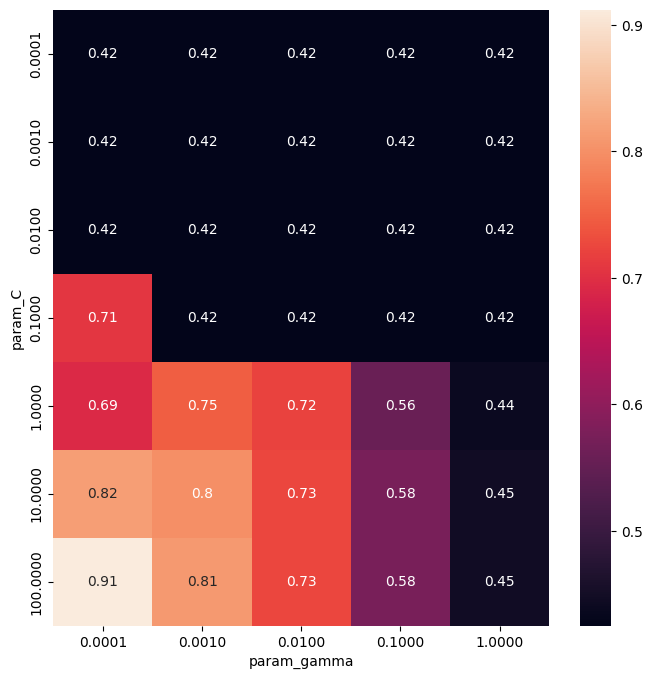

In [14]:
from src.visualization import visualize
visualize.gridsearch_heatmap(grid_search, param_grid, figsize=(8,8))

Okay, so we have a hotspot. But our scan is very rough: every value we test is 10 times as big. We will probably want to do this a bit more finegrained.

however, this is very usefull for a quick scan. So let's wrap this in a function, and repeat this while zooming in on the heatmap. The process is this:

1. Make sure that your first gridsearch is large enough to have 'low performance' in the borders.
2. Zoom in on the hotspot, tuning up the gradient of the parameters. Make sure you dont overdo: 25 values for C and 25 values for gamma results in 25x25 combinations. This can take quite some time if you overdo this (eg a grid with 100 values of $C$ and 100 values of $\gamma$ results in 10.000 times fitting the SVC.)

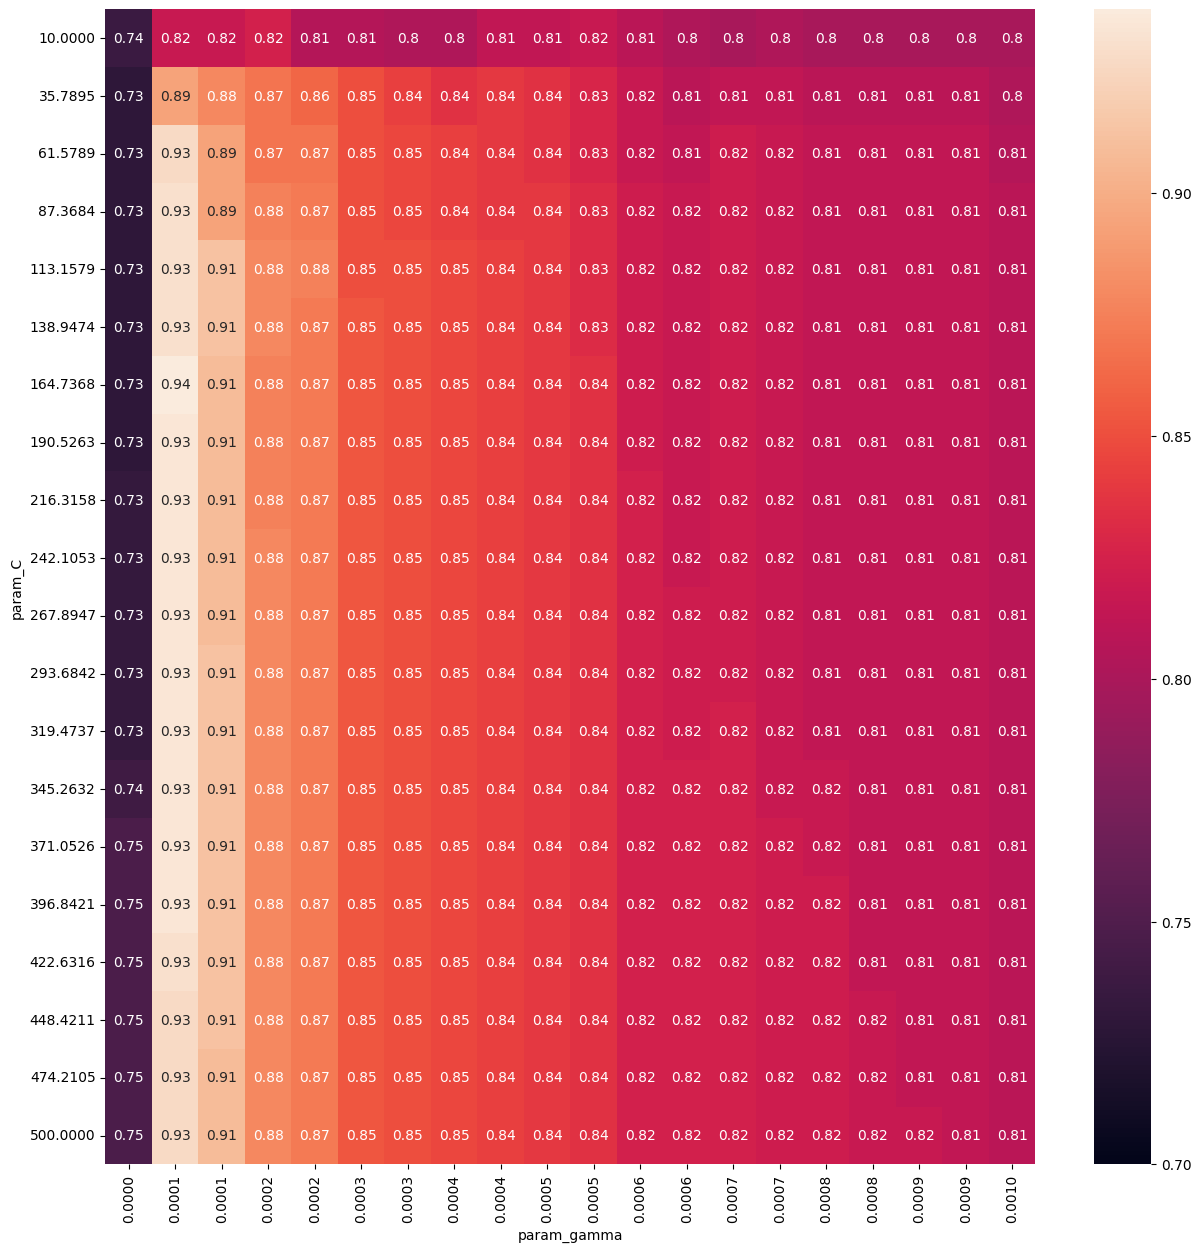

In [15]:
from src.models import train_model

# Set parameter grid
# zoom in on what looks like a usefull are for C and gamma
param_grid = {
    'C': np.linspace(10, 500, 20),
    'gamma': np.linspace(1e-7, 1e-3, 20),
    }


# often it is usefull to fiddle with the vmin to increase the contrast of colors
grid_search = train_model.search_and_fit(model=SVC(),
                                         X=X_train, 
                                         y=y_train, 
                                         param_grid=param_grid, 
                                         vmin=0.7,
                                         figsize=(15,15),
                                         cv = 3)

As you can see, the optimal gamma is low, the optimal C is pretty high.

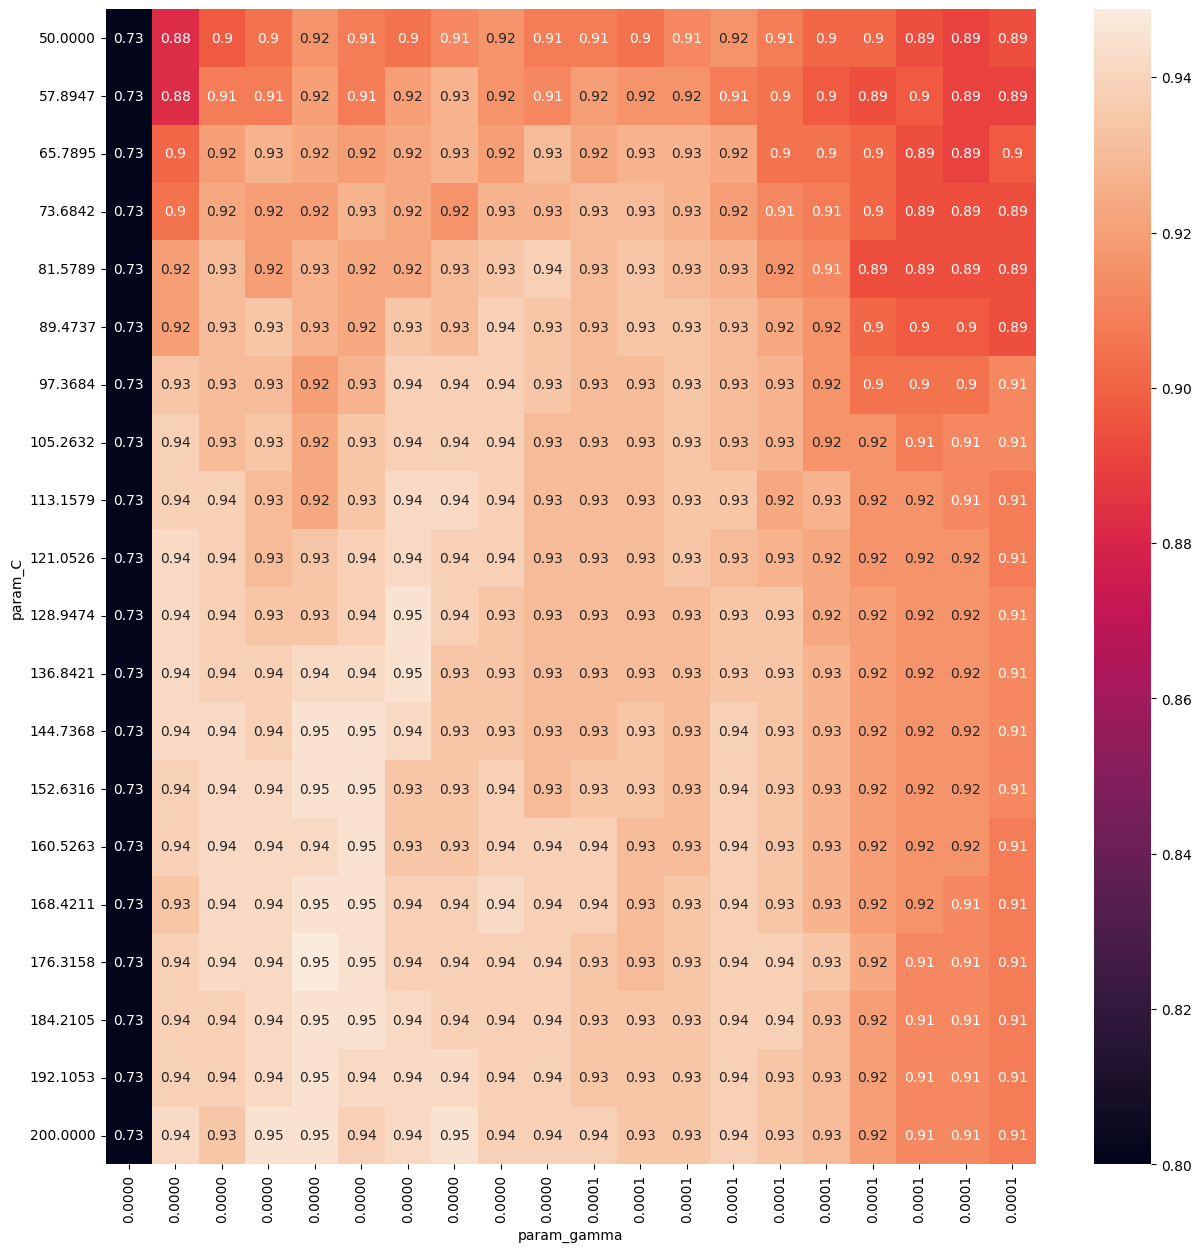

In [16]:
# Set parameter grid
# zoom in on what looks like a usefull are for C and gamma
param_grid = {
    'C': np.linspace(50, 200, 20),
    'gamma': np.linspace(1e-7, 1e-4, 20),
    }


# often it is usefull to fiddle with the vmin to increase the contrast of colors
grid_search = train_model.search_and_fit(model=SVC(),
                                         X=X_train, 
                                         y=y_train, 
                                         param_grid=param_grid, 
                                         vmin=0.8,
                                         figsize=(15,15),
                                         cv = 3)

In [17]:
# Print best parameters and corresponding score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:  {}".format(best_parameters))
print("Best score:       {:.2f}".format(best_score))

Best parameters:  {'C': 176.31578947368422, 'gamma': 2.113157894736842e-05}
Best score:       0.95


A question that is not straightforward to answer, is: are the 'best parameters' returned by the grid search, actually the best parameters?

Look at the heatmap; you can often find little islands of good practice.

The downside of an island is, that you might "drop off" and fall into a deep
abyss of low performance if the data changes just a little bit.

That's why I would prefere a big area of high performance and picking the middle
of that over letting the automated process pick a higher perform that's in the
middle of a very small spot.

At a minimum, you should check it visually.

# Adding pipelines
Another usefull feature is to create a pipeline of functions.

In [18]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = sns.load_dataset("penguins")
data = data.drop(["island", "sex"], axis=1).dropna()
y = data["species"]
X = data.drop("species", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


from sklearn.pipeline import Pipeline
# Build pipeline
pipe = Pipeline(
    [
        ("scaler", StandardScaler()), # we add a scaler
        ("svm", SVC()) # and a model
    ]
)

In general, if you have multiple steps in your process, it's a good idea to
fixate the steps with a function. This protects you from making mistakes in the
order of the process. In addition to that, this fixes the problem with the order
of scaling and splitting: this wil fit the scaler on the training, and apply
that fit to the testset.

In the example below, you see combined the scaler and the SVC. You can add more functions to
that, and usually you will. In a real life dataset, your preprocessing might
contain more then ten steps and contain cleaning, modification (like scaling), feature
extraction, etc.

A Pipeline is a nice way to fixate multiple steps in a proces.
It takes a list of name-estimator pairs. 

```
pipe = Pipeline(
    [
        ("name_of_first_estimator", FirstEstimator()), 
        ("name_of_second_estimator", SecondEstimator())
    ]
)
```


All but the last one must
be transformers (meaning, they must implement a `fit_transform()` method),
something that all sklearn models do. But you can easily create a custom
transformer if you implement this method.

Calling `fit()` on the pipe calls the `fit_transform()` methods sequentially,
and `fit()` on the final method.

If you want to feed a range of parameters, you can give `GridSearchCV` a
dictionary with `{str: List}` pairs. To indicate which key should be used for
which estimator, you should use a double underscore.

So, if the name you gave to and estimator is "scaler", the `GridSearchCV`
function will look for "scaler__parameter". Look at the example below:

In [19]:
# note the double underscore in the parameter names. This refers to the name-estimator pairs in the pipeline.
param_grid = {'svm__C': [10**x for x in range(-4,3)],
              'svm__gamma': [10**x for x in range(-4,1)]}

gridsearch = GridSearchCV(pipe, param_grid=param_grid, cv=5)

# Fit GridSearchCV
gridsearch.fit(X_train, y_train)

# Print results (CV accuracy, test set score, best parameters)
print(gridsearch.best_score_)
print(gridsearch.score(X_test, y_test))
print(gridsearch.best_params_)

0.996078431372549
0.9883720930232558
{'svm__C': 100, 'svm__gamma': 0.1}


Note how adding the scaler means we need to start the hyperparameter tuning again!
Changing the scales can impact the scales of the hyperparameters a lot!

In principle, this is exectly the same as what we did before. It just wraps more into a solid architecture, making sure that all steps in the datapreparation are executed in the right sequence.

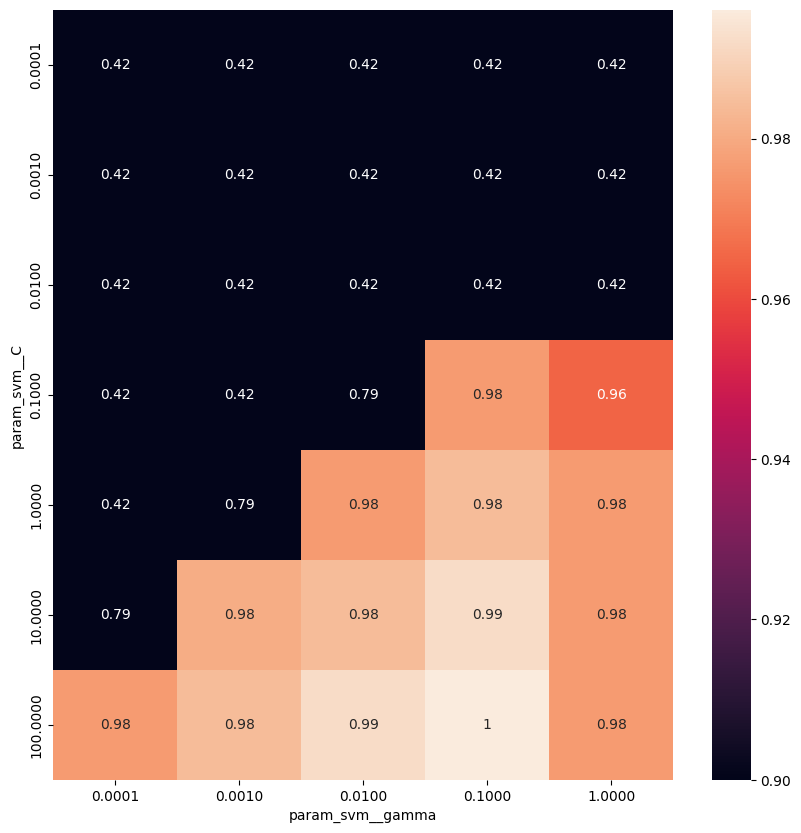

In [20]:
visualize.gridsearch_heatmap(gridsearch, param_grid, vmin=0.9, figsize=(10,10))